In [21]:
!pip install transformers torch scikit-learn openpyxl

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import pandas as pd
import os
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score

In [39]:
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [40]:
EXCEL_FILE = '/content/drive/MyDrive/Extended AMUSED Dataset (1)/Extended Amused dataset/Final dataset.xlsx'     # Excel file with 4 sheets
SHEET_NAME = 'Events'                  # Sheet containing claim + label
RETRIEVAL_FILE = '/content/retrieval_results (2).csv'
EVIDENCE_FOLDER = '/content/drive/MyDrive/Extended AMUSED Dataset (1)/Extended Amused dataset/evidence'
TOP_K = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [41]:
# 1. Load claims sheet
claims_df = pd.read_excel(EXCEL_FILE, sheet_name=SHEET_NAME)
claims_df = claims_df[['claim-id', 'claim', 'label']]
print(f"✅ Loaded {len(claims_df)} claims")

✅ Loaded 188 claims


In [42]:
# 2. Load retrieval results and merge
retrieved_df = pd.read_csv(RETRIEVAL_FILE)
merged_df = pd.merge(retrieved_df, claims_df, on=['claim-id', 'claim'])
print(f"🔗 Merged retrieval results: {len(merged_df)} rows")

🔗 Merged retrieval results: 188 rows


In [43]:
merged_df.head()

,claim-id,claim,gold-evidence,retrieved,MRR@10,label
0,c1,A user on X (formerly Twitter) posted: “Momina...,g1,"['g1', 'page_40', 'g18', 'page_7305', 'page_25...",1.000000,1
1,c2,A video shows civilians passengers released by...,g2,"['g11', 'page_3', 'g2', 'g15', 'g17', 'page_21...",0.333333,1
2,c3,"Water tanker runs over man, pregnant wife and ...",g3,"['g3', 'page_5251', 'page_4747', 'g6', 'page_6...",1.000000,0
3,c4,"In Punjab, electricity bill will be free for t...",g4,"['g4', 'page_7537', 'page_9044', 'page_5960', ...",1.000000,1
4,c5,"people burning the Pakistani flag, with the ca...",g5,"['g5', 'page_98', 'page_2121', 'page_6069', 'p...",1.000000,1


In [44]:
# 3. Load evidence texts
evidence_texts = {}
for fname in os.listdir(EVIDENCE_FOLDER):
    if fname.endswith('.txt'):
        with open(os.path.join(EVIDENCE_FOLDER, fname), 'r', encoding='utf-8') as f:
            evidence_texts[fname[:-4]] = f.read().strip()

In [45]:
MODEL_ID = "NorGLM/Entailment"
MAX_LEN = 512

In [46]:
# 4. Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, fast_tokenizer=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

model = BertForSequenceClassification.from_pretrained(MODEL_ID)
model.resize_token_embeddings(len(tokenizer))
model.to(DEVICE)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50104, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [47]:
# Label map (optional, for printing)
label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}

In [48]:
# 5. Prediction function with combined entailment+neutral as positive
def predict_binary_label(claim, evidence):
    inputs = tokenizer(
        claim,
        evidence,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN
    ).to(DEVICE)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1)

    # Combine entailment(0) and neutral(1) as positive class probability
    positive_prob = probs[0][0].item() + probs[0][1].item()
    pred_label = 1 if positive_prob > 0.5 else 0

    # For debug, you can also return the highest single label
    single_pred_label = torch.argmax(probs, dim=1).item()
    single_pred_name = label_map[single_pred_label]

    return pred_label, positive_prob, single_pred_name


In [49]:
# 6. Run entailment on top-1 evidence and store results
results = []
print("🚀 Running entailment with combined entailment+neutral as positive...")

for _, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
    claim_id = row['claim-id']
    claim = row['claim']
    true_label = row['label']

    # Extract top-1 evidence from retrieval (assuming list-like string)
    try:
        retrieved_list = eval(row['retrieved'])
        top1_evidence_name = retrieved_list[0] if retrieved_list else None
    except Exception:
        top1_evidence_name = None

    if top1_evidence_name and top1_evidence_name in evidence_texts:
        evidence_text = evidence_texts[top1_evidence_name]
        pred_binary, pos_prob, single_pred = predict_binary_label(claim, evidence_text)
    else:
        pred_binary = 0
        pos_prob = 0.0
        single_pred = 'missing'

    results.append({
        'claim-id': claim_id,
        'claim': claim,
        'true_label': true_label,
        'top1_evidence': top1_evidence_name,
        'predicted_binary_label': pred_binary,
        'positive_prob': pos_prob,
        'single_pred_label': single_pred
    })


🚀 Running entailment with combined entailment+neutral as positive...


100%|██████████| 188/188 [00:07<00:00, 26.12it/s]


In [50]:
# 7. Evaluation
# Only proceed with evaluation if there are results
if results:
    results_df = pd.DataFrame(results)

    acc = accuracy_score(results_df['true_label'], results_df['predicted_binary_label'])
    f1 = f1_score(results_df['true_label'], results_df['predicted_binary_label'])

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(results_df['true_label'], results_df['predicted_binary_label']))

    print("\nClassification Report:")
    print(classification_report(results_df['true_label'], results_df['predicted_binary_label']))

    # 8. Save detailed results
    results_df.to_csv("entailment_predictions_results.csv", index=False)
    print("📁 Results saved to 'entailment_predictions_results.csv'")
else:
    print("\n⚠️ No results to evaluate. Merged dataframe was likely empty.")


✅ Accuracy: 0.7500
✅ F1 Score: 0.8498

Confusion Matrix:
[[  8  32]
 [ 15 133]]

Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.20      0.25        40
           1       0.81      0.90      0.85       148

    accuracy                           0.75       188
   macro avg       0.58      0.55      0.55       188
weighted avg       0.71      0.75      0.72       188

📁 Results saved to 'entailment_predictions_results.csv'


In [51]:
# 8. Save detailed results
results_df.to_csv("entailment_predictions_results.csv", index=False)
print("📁 Results saved to 'entailment_predictions_results.csv'")

📁 Results saved to 'entailment_predictions_results.csv'


In [55]:
import matplotlib.pyplot as plt
import numpy as np

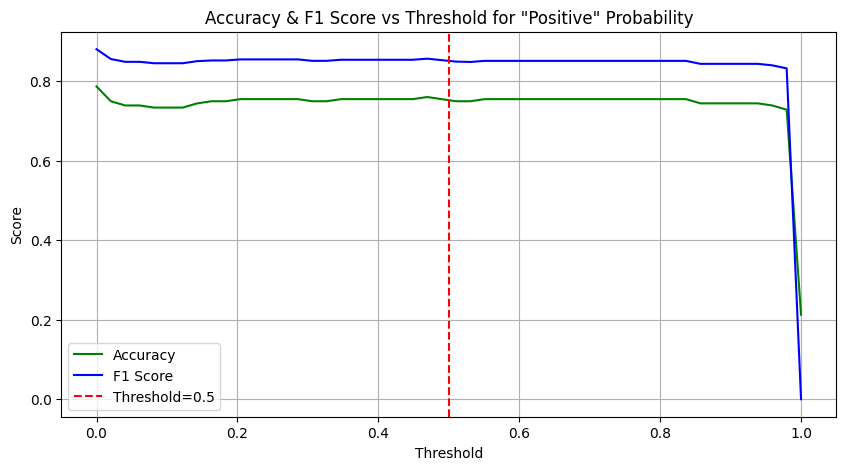

In [59]:
# 9. Plot Accuracy and F1 over thresholds
thresholds = np.linspace(0, 1, 50)
accuracies = []
f1s = []

for thresh in thresholds:
    preds = (results_df['positive_prob'] > thresh).astype(int)
    accuracies.append(accuracy_score(results_df['true_label'], preds))
    f1s.append(f1_score(results_df['true_label'], preds))

plt.figure(figsize=(10,5))
plt.plot(thresholds, accuracies, label='Accuracy', color='green')
plt.plot(thresholds, f1s, label='F1 Score', color='blue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold=0.5')
plt.title('Accuracy & F1 Score vs Threshold for "Positive" Probability') # Updated title for clarity
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()